In [1]:
# Exploratory Data Analysis - Pilot

In [2]:
# В этом кейсе мы познакомимся с тем, как проводить EDA на примере исследования о качестве шоколадных батончиков. 
# EDA поможет нам первично проверить гипотезу о связи различных переменных с рейтингом батончика.

# В датасете представлены следующие данные:

# ● Bar id — ID батончика в базе данных
# ● Company (Maker-if known) — название компании, изготовившей батончик.
# ● Specific Bean Origin or Bar Name — точное место происхождения какао-бобов.
# ● Broad Bean Origin — название региона, где были выращены какао-бобы.
# ● Company Location — страна, в которой произведён шоколадный батончик.
# ● Bean Type — вид какао-бобов, используемых в батончике.
# ● REF — числовое значение, показывающее, как давно ревью было добавлено в базу. Чем выше значение, тем более свежее ревью.
# ● Review Date — год публикации рецензии.
# ● Cocoa Percent — процент какао в шоколаде.
# ● Rating — оценка батончика фокус-группой.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from collections import Counter

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

cacao = pd.read_csv('cacao_flavors.csv')

In [4]:
# columns
cacao.columns = ["bar_id", "company", "specific_origin", "ref", "review_date", "cocoa_percent", "company_location", "rating", "bean_type", "broad_origin"]
cacao.head(10)

,bar_id,company,specific_origin,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_origin
0,1,A. Morin,Agua Grande,1876,2016,63%,France,11.50,,Sao Tome
1,2,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,3,A. Morin,Atsane,1676,2015,670%,France,3.00,,Togo
3,4,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,5,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
5,6,A. Morin,Carenero,1315,2014,70%,France,2.75,Criollo,Venezuela
6,7,A. Morin,Cuba,1315,2014,70%,France,3.50,,Cuba
7,8,A. Morin,Sur del Lago,1315,2014,70%,France,11.50,Criollo,Venezuela
8,9,,Puerto Cabello,1319,2014,70%,France,3.75,Criollo,Venezuela
9,10,A. Morin,Pablino,1319,2014,70%,France,4.00,,Peru


1795


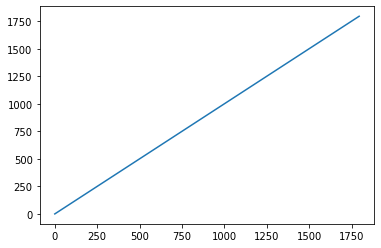

In [5]:
# Bar Id
print(cacao.bar_id.nunique())
plt.plot(cacao.bar_id)

In [6]:
cacao.drop(['bar_id'], inplace = True, axis = 1)

In [7]:
# Company
# 2.3.1
print(len(set(cacao.company)) - 1) # -1, cuz it's an empty value

407


In [8]:
cacao.company = cacao.company.apply(lambda x: None if x.strip() == '' else x)
display(pd.DataFrame(cacao.company.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:"#Число 10 взято для ориентира, можно брать другое
      , (cacao.company.value_counts() > 10).sum())
cacao.loc[:, ['company']].info()

,company
Soma,45
Fresco,26
Bonnat,26
Pralus,25
Domori,22
...,...
Bernachon,1
Kerchner,1
Friis Holm,1
Baravelli's,1


Значений, встретившихся в столбце более 10 раз: 30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 1 columns):
company    1696 non-null object
dtypes: object(1)
memory usage: 14.1+ KB


In [9]:
# Specific origin 
# 2.3.2
print(len(set(cacao.specific_origin)) - 1) # -1, cuz it's empty

1012


count    1795.000000
mean     1035.904735
std       552.886365
min         5.000000
25%       576.000000
50%      1069.000000
75%      1502.000000
max      1952.000000
Name: ref, dtype: float64

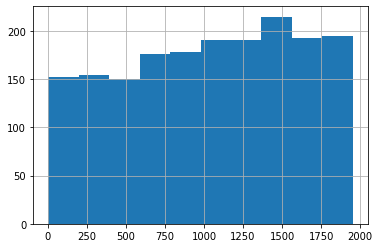

In [10]:
# REF
cacao.ref.hist()
cacao.ref.describe()

{'whiskers': [<matplotlib.lines.Line2D at 0x1a21c1d0d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a21c1db10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a21c12450>],
 'medians': [<matplotlib.lines.Line2D at 0x1a21c26590>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a21c26a90>],
 'means': []}

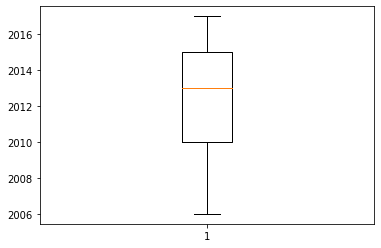

In [11]:
# Review date
plt.boxplot(cacao.review_date)

count    1795.000000
mean     2012.325348
std         2.927210
min      2006.000000
25%      2010.000000
50%      2013.000000
75%      2015.000000
max      2017.000000
Name: review_date, dtype: float64

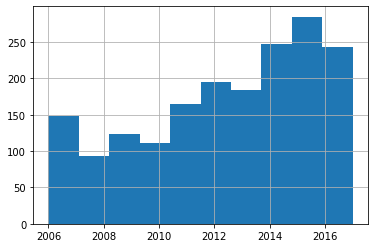

In [12]:
cacao.review_date.hist()
cacao.review_date.describe()

In [13]:
# cocoa_percent
cacao.cocoa_percent = cacao.cocoa_percent.apply(lambda x: float(x.replace('%', '')))

25-й перцентиль: 70.0, 75-й перцентиль: 75.0, IQR: 5.0,  Границы выбросов: [62.5, 82.5].


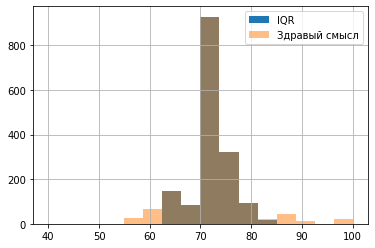

In [14]:
# Самый простой способ отфильтровать выбросы — воспользоваться формулой интерквартильного расстояния (межквартильного размаха). Выбросом считаются такие значения, которые лежат вне рамок

# percentile(25) -1.5*IQR : percentile(75)+1.5*IQR,
# где IQR = percentile(75) - percentile(25).

median = cacao.cocoa_percent.median()
IQR = cacao.cocoa_percent.quantile(0.75) - cacao.cocoa_percent.quantile(0.25)
perc25 = cacao.cocoa_percent.quantile(0.25)
perc75 = cacao.cocoa_percent.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), 
      '75-й перцентиль: {},'.format(perc75), 
      "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
cacao.cocoa_percent.loc[cacao.cocoa_percent.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 16
                                                                                              , range = (40, 100), 
                                                                                             label = 'IQR')
cacao.cocoa_percent.loc[cacao.cocoa_percent <= 100].hist(alpha = 0.5, bins = 16, range = (40, 100),
                                                        label = 'Здравый смысл')
plt.legend();

In [15]:
# filter 
cacao = cacao.loc[cacao.cocoa_percent <= 100]

In [16]:
# company_location
display(pd.DataFrame(cacao.company_location.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:", (cacao.company_location.value_counts()>10).sum())
cacao.loc[:, ['company_location']].info()

,company_location
U.S.A.,756
France,155
Canada,124
U.K.,94
Italy,63
...,...
Czech Republic,1
Eucador,1
Martinique,1
India,1


Значений, встретившихся в столбце более 10 раз: 22
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1776 entries, 0 to 1794
Data columns (total 1 columns):
company_location    1776 non-null object
dtypes: object(1)
memory usage: 27.8+ KB


count    1776.000000
mean        3.425816
std         1.759007
min         1.000000
25%         3.000000
50%         3.250000
75%         3.500000
max        19.750000
Name: rating, dtype: float64

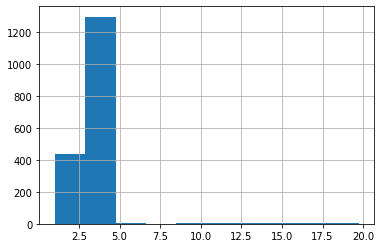

In [17]:
# rating
cacao.rating.hist()
cacao.rating.describe()

25-й перцентиль: 3.0, 75-й перцентиль: 3.5, IQR: 0.5,  Границы выбросов: [2.25, 4.25].


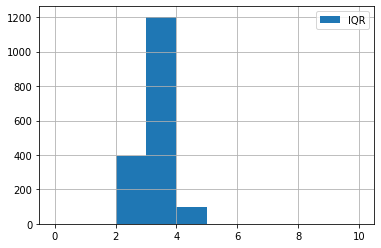

In [36]:
median = cacao.rating.median()
IQR = cacao.rating.quantile(0.75) - cacao.rating.quantile(0.25)
perc25 = cacao.rating.quantile(0.25)
perc75 = cacao.rating.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
cacao.rating.loc[cacao.rating.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), 
                                                                                             label = 'IQR')
plt.legend();

In [19]:
# filter
cacao = cacao.loc[cacao.rating.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

In [20]:
# bean_type
# put 'None' instead of ''
cacao.bean_type = cacao.bean_type.astype(str).apply(lambda x: None if x.strip() == '' else x)

In [21]:
display(pd.DataFrame(cacao.bean_type.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:", (cacao.bean_type.value_counts()>10).sum())
print("Уникальных значений:", cacao.bean_type.nunique())
cacao.loc[:, ['bean_type']].info()

,bean_type
Trinitario,401
Criollo,147
Forastero,81
Forastero (Nacional),50
"Criollo, Trinitario",37
Blend,36
Forastero (Arriba),30
Criollo (Porcelana),10
"Trinitario, Criollo",9
Forastero (Parazinho),8


Значений, встретившихся в столбце более 10 раз: 7
Уникальных значений: 41
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
bean_type    861 non-null object
dtypes: object(1)
memory usage: 26.4+ KB


In [22]:
# put 'None' instead of null, 'nan'
# put commas instead of braces
cacao.bean_type = cacao.bean_type.apply(
    lambda x: 
    None if pd.isnull(x) else 
    None if x == 'nan'else 
    x if '(' not in x else x[:x.find('(')].strip()
)

In [23]:
display(pd.DataFrame(cacao.bean_type.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:", (cacao.bean_type.value_counts()>10).sum())
print("Уникальных значений:", cacao.bean_type.nunique())
cacao.loc[:, ['bean_type']].info()

,bean_type
Trinitario,405
Forastero,179
Criollo,165
"Criollo, Trinitario",37
Blend,36
"Trinitario, Criollo",9
Nacional,5
Matina,3
EET,3
Beniano,3


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 21
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
bean_type    860 non-null object
dtypes: object(1)
memory usage: 26.4+ KB


In [24]:
# broad_origin
cacao.broad_origin = cacao.broad_origin.astype(str).apply(
    lambda x: 
    None if x.strip() == '' else x
)
cacao.broad_origin = cacao.broad_origin.apply(
    lambda x: 
    None if pd.isnull(x) else 
    None if x == 'nan' else 
    x if '(' not in x else x[:x.find('(')].strip()
)
display(pd.DataFrame(cacao.broad_origin.value_counts()))
print("Значений, встретившихся в столбце более 10 раз:", (cacao.broad_origin.value_counts() > 10).sum())
print("Уникальных значений:", cacao.broad_origin.nunique())
cacao.loc[:, ['broad_origin']].info()

,broad_origin
Venezuela,202
Ecuador,179
Peru,160
Madagascar,138
Dominican Republic,135
...,...
"Ecuador, Costa Rica",1
"Peru, Madagascar",1
"Ven.,Ecu.,Peru,Nic.",1
"Guat., D.R., Peru, Mad., PNG",1


Значений, встретившихся в столбце более 10 раз: 25
Уникальных значений: 94
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
broad_origin    1630 non-null object
dtypes: object(1)
memory usage: 26.4+ KB


In [25]:
def fix_countries(x):
    if pd.isnull(x):
        return x
    if x == 'nan':
        return None
    x = x.replace(' ', '')
    x = x.replace('/', ',') # Venezuela/ Ghana
    x = x.replace('&', ',')
    if '(' in x:
        x = x[:x.find('(')] #Peru(SMartin,Pangoa,nacional)
    x = x.replace('Guat.', 'Guatemala')
    
    if 'Ven' in x and 'Venezuela' not in x:
        x = x.replace('Venez', 'Venezuela') #Venez,Africa,Brasil,Peru,Mex
        x = x.replace('Ven,', 'Venezuela,') #Ven, Trinidad, Ecuador
        x = x.replace('Ven.', 'Venezuela') #Ven., Trinidad, Mad.
        if 'Ven' in x and 'Venezuela' not in x:
            x = x.replace('Ven', 'Venezuela')
    x = x.replace('Dom.Rep.', 'DomincanRepublic')
    x = x.replace('DR', 'DomincanRepublic')
    x = x.replace('Dom.Rep', 'DomincanRepublic')
    x = x.replace('D.R.', 'DomincanRepublic')
    x = x.replace('DominicanRep.', 'DomincanRepublic')
    x = x.replace('Domin.Rep', 'DomincanRepublic')
    x = x.replace('Domin.Re', 'DomincanRepublic')
    
    if 'Jam' in x and 'Jamaica' not in x:
        x = x.replace('Jam', 'Jamaica')
        
    if 'Mad.' in x and 'Madagascar' not in x:
        x = x.replace('Mad.', 'Madagascar')
    elif 'Mad' in x and 'Madagascar' not in x:
        x = x.replace('Mad', 'Madagascar')
    elif 'Ma' in x and 'Madagascar' not in x:
        x = x.replace('Ma', 'Madagascar')
    if 'Hait' in x and 'Haiti' not in x:
        x = x.replace('Hait', 'Haiti')
    if 'Per' in x and 'Peru'  not in x:
        x = x.replace('Per', 'Peru')
    x = x.replace('Nic.', 'Nicaragua')
    x = x.replace('Gre.', 'Grenada')
    x = x.replace('PNG', 'PapuaNewGuinea')
    if 'Mex' in x and 'Mexico' not in x:
        x = x.replace('Mex', 'Mexico')
    x = x.replace('Haw.', 'Hawaii')
    x = x.replace('Ecuad.', 'Ecuador')
    x = x.replace('Ecu.', 'Ecuador')
    
    return x

In [26]:
# fix countries
cacao.broad_origin = cacao.broad_origin.apply(fix_countries).sort_values()
cacao.broad_origin.unique()

array(['Togo', 'Peru', 'Venezuela', 'Cuba', 'Panama', 'Madagascar',
       'Brazil', 'Ecuador', 'Colombia', 'Burma', 'PapuaNewGuinea',
       'Bolivia', 'Fiji', 'Mexico', 'Indonesia', 'Trinidad', 'Vietnam',
       'Nicaragua', 'Tanzania', 'DominicanRepublic', 'Ghana', 'Belize',
       None, 'Jamaica', 'Honduras', 'CostaRica', 'Guatemala', 'Haiti',
       'Congo', 'Philippines', 'DomincanRepublic', 'Madagascarlaysia',
       'DomincanRepublic,Bali', 'Venezuela,Africa,Brasil,Peru,Mexico',
       'Gabon', 'IvoryCoast', 'Carribean', 'SriLanka', 'PuertoRico',
       'Grenada', 'SaoTome', 'Uganda', 'Madagascarrtinique',
       'SaoTome,Principe', 'Vanuatu', 'Australia', 'Liberia',
       'Ecuador,CostaRica', 'WestAfrica', 'Hawaii', 'St.Lucia',
       'CostRica,Venezuela', 'Peru,Madagascar', 'Venezuela,Trinidad',
       'Trinidad,Tobago', 'Venezuela,Trinidad,Ecuador',
       'SouthAmerica,Africa', 'India', 'Africa,Carribean,C.Am.',
       'Trinidad-Tobago', 'Peru,Ecuador,Venezuela',
       'V

In [27]:

# show countries
display(pd.DataFrame(cacao.broad_origin.value_counts()))
print('Значений, упомянутых более 10 раз:', (cacao.broad_origin.value_counts()>10).sum())
print("Уникальных значений:", cacao.broad_origin.nunique())
cacao.loc[:, ['broad_origin']].info()

,broad_origin
Venezuela,202
Ecuador,179
Peru,160
Madagascar,138
DominicanRepublic,135
...,...
"Venezuela,Trinidad,Madagascar",1
Nigeria,1
"Venezuela,Trinidad",1
"Peru,Ecuador",1


Значений, упомянутых более 10 раз: 25
Уникальных значений: 93
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1690 entries, 1 to 1794
Data columns (total 1 columns):
broad_origin    1630 non-null object
dtypes: object(1)
memory usage: 26.4+ KB


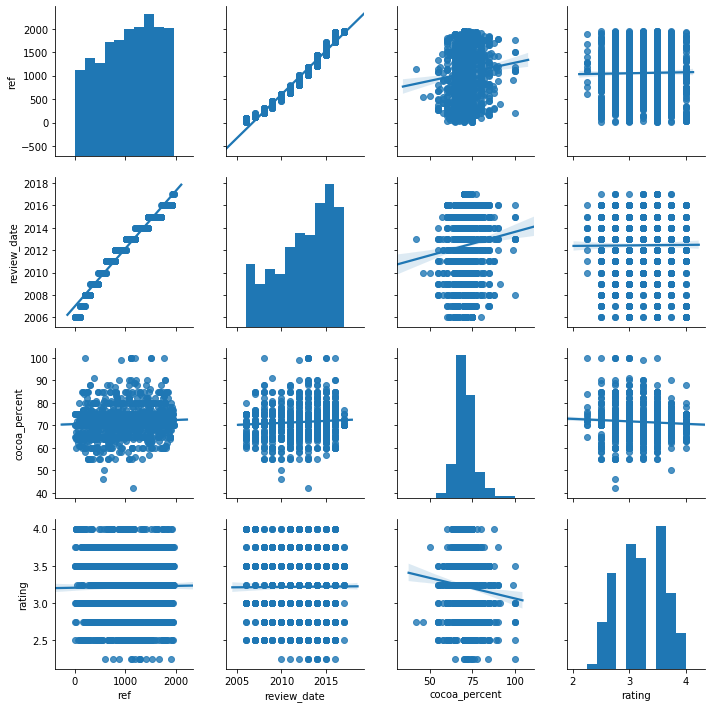

In [28]:
# 2.5
sns.pairplot(cacao, kind = 'reg')

In [29]:
cacao.corr()

,ref,review_date,cocoa_percent,rating
ref,1.000000,0.984913,0.083765,0.016189
review_date,0.984913,1.000000,0.086523,0.006703
cocoa_percent,0.083765,0.086523,1.000000,-0.078156
rating,0.016189,0.006703,-0.078156,1.000000


In [30]:
# 2.6 
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='rating', 
                data=cacao.loc[cacao.loc[:, column].isin(cacao.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

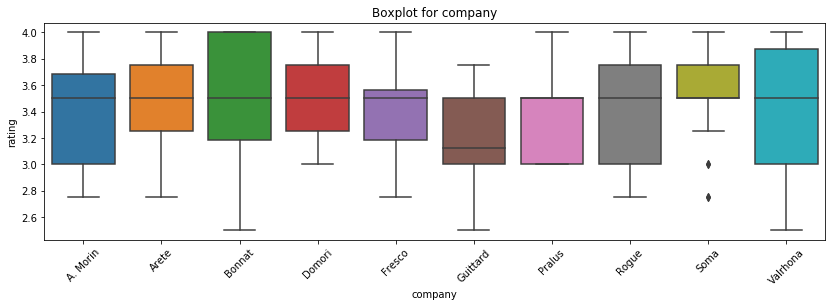

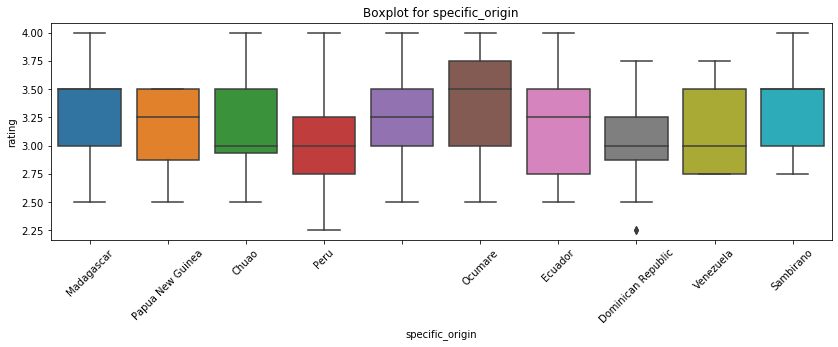

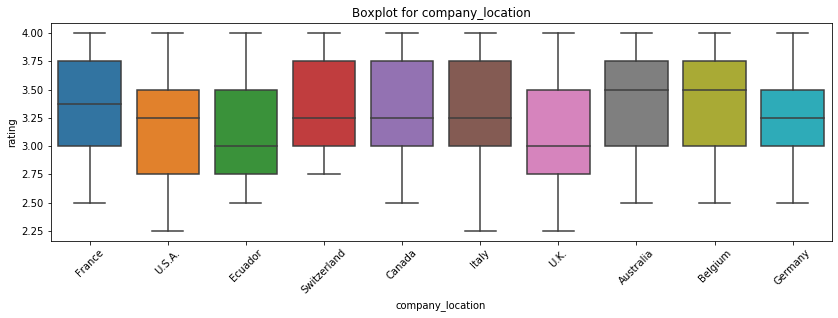

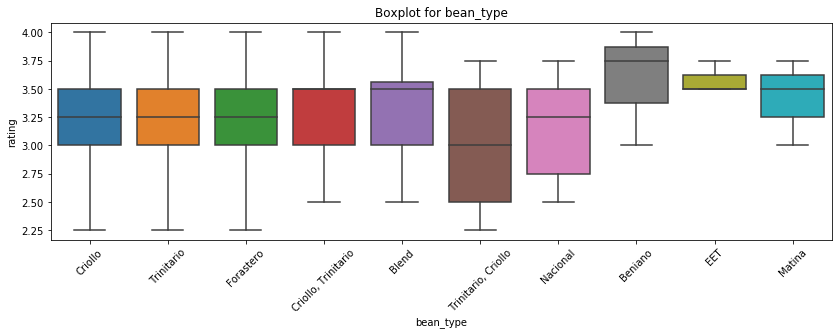

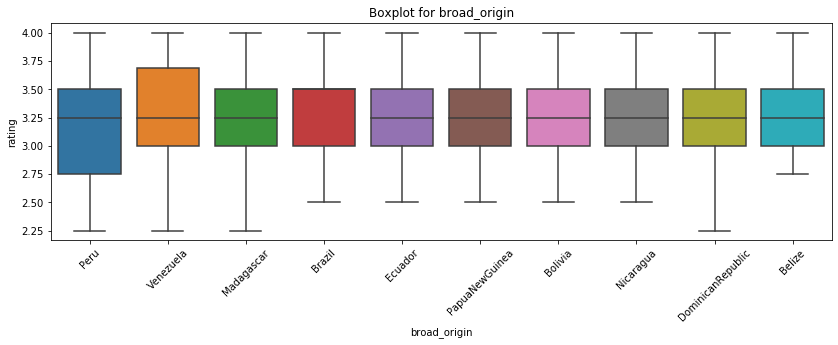

In [31]:
for col in ['company', 'specific_origin', 'company_location', 'bean_type', 'broad_origin']:
    get_boxplot(col)

In [32]:
def get_stat_dif(column):
    cols = cacao.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(cacao.loc[cacao.loc[:, column] == comb[0], 'rating'], 
                        cacao.loc[cacao.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [33]:
for col in ['company', 'specific_origin', 'company_location', 'bean_type', 'broad_origin']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки company
Найдены статистически значимые различия для колонки specific_origin
Найдены статистически значимые различия для колонки company_location


In [34]:
cacao_for_model = cacao.loc[:, ['company', 'specific_origin', 'company_location', 'review_date', 'cocoa_percent']]
cacao_for_model.head()

,company,specific_origin,company_location,review_date,cocoa_percent
1,A. Morin,Kpime,France,2015,70.0
3,A. Morin,Akata,France,2015,70.0
4,A. Morin,Quilla,France,2015,70.0
5,A. Morin,Carenero,France,2014,70.0
6,A. Morin,Cuba,France,2014,70.0


In [35]:
# 2.7

# Итак, в результате EDA для анализа влияния параметров шоколада на экспертную оценку шоколадных батончиков были получены следующие выводы:

# ● В данных достаточно мало пустых значений, только столбец bean_type был заполнен в малом количестве случаев.
# ● Выбросы найдены только в столбцах с рейтингом и содержанием какао в шоколаде батончиков, 
# что позволяет сделать вывод о том, что данные достаточно чистые.
# ● Положительная корреляция параметра review_date и rating может говорить о том, 
# что с годами рейтинги потихоньку завышаются, либо батончики становятся лучше.
# ● Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, 
# это company, specific_origin, company_location, review_date и cocoa_percent.